In [1]:
import pandas as pd
import random as random
import numpy as np
from functools import partial
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# generate data sets - numerical alone

def dataset_gen(features, coeffs, error, num_rows):
    features2 = features.copy()
    coeffs2 = coeffs.copy()
    initial_list = [np.random.normal(0,1,len(coeffs)) for x in range(0,num_rows)]
    df = pd.DataFrame(initial_list,columns = features2)
    df['Error'] = list(error(num_rows))
    features2.append('Error')
    coeffs2.append(1.0)
    df['Target'] = (df[features2]*coeffs2).sum(axis=1)
    return df


# helper function - takes a list of 2-tuples and makes it into a list of 
# the first entry followed by the second entry

def split_list(y):
    a = [i[0] for i in y]
    b = [i[1] for i in y]
    return a + b

# generate data sets - numerical + categorical


def dataset_gen2(features_num, coeffs_num, features_cat, coeffs_cat, error, num_rows):

    # first creates values for input numerical values
    initial_list_num = [list(np.random.normal(0,1,len(coeffs))) for x in range(0,num_rows)]
    
    # then creates a random choice of the categorical variables
    # two columns for each categorical variable - the category and the n
    values_cat = [x+'val' for x in features_cat]
    all_cat = features_cat + values_cat
    initial_list_cat = [[random.choice(x) for x in coeffs_cat] for y in range(0,num_rows)]
    initial_list_cat2 = [split_list(x) for x in initial_list_cat]
    
    # finally joins them all and creates a dataframe
    full_features = features_num + all_cat
    full_data = [x+y for x,y in zip(initial_list_num, initial_list_cat2)]
    df = pd.DataFrame(full_data,columns = full_features)

    # then first multiplies the continuous variables 
    df['Target1'] = (df[features_num]*coeffs_num).sum(axis=1)
    singles1 = [1 for x in values_cat]
    
    # followed by categorical variables
    df['Target2'] = (df[values_cat]*singles1).sum(axis=1)

    #and finally an error term
    df['Error'] = list(error(num_rows))
    
    # to generate the final target variable
    df['Target3'] = df['Target1'] + df['Target2'] + df['Error']

    return df

def generate_coeffs(train_features, train_target, features):
    X2 = sm.add_constant(train_features)
    est = sm.OLS(train_target, X2, missing = 'drop')
    est2 = est.fit()
    frame = [(est2.params[a],est2.pvalues[a]) for a in features]
    return frame

#creates functions to stretch and add noise to the data

def nuller(prob_null, stretch, x):
    temp = random.random()
    if temp < prob_null:
        return x*stretch
    else:
        return None



In [3]:
features = ['x1','x2','x3','x4','x5']
coeffs = [1.1,2.3,0,1.1,-2.5]
coeffs_cat = [[(0,0.4),(1,0.3)],[('a',0),('b',0.1),('c',0.9)]]
features_cat = ['x6','x7']

features2 = features.copy()
features2.append('const')
coeffs_frame = []

for i in range (0,50):
    dataset = dataset_gen(features,coeffs,partial(np.random.normal,0,1),10000)
    train_features = dataset[features]
    train_target = dataset['Target']
    frame = generate_coeffs(train_features, train_target, features2)
    coeffs_frame.append(frame)

df = pd.DataFrame(coeffs_frame, columns= features2)

df["x1coeff"] = df["x1"].apply(lambda x: x[0])
df["x2coeff"] = df["x2"].apply(lambda x: x[0])
df["x3coeff"] = df["x3"].apply(lambda x: x[0])
df["x4coeff"] = df["x4"].apply(lambda x: x[0])
df["x5coeff"] = df["x5"].apply(lambda x: x[0])

In [4]:
df.head()

x1                         x2  \
0  (1.0799081106987996, 0.0)  (2.2892116422718716, 0.0)   
1  (1.1104432766473047, 0.0)   (2.299373999624974, 0.0)   
2  (1.0847232369187454, 0.0)   (2.300725983494268, 0.0)   
3  (1.0866502167364922, 0.0)  (2.2860857724836876, 0.0)   
4  (1.0846176244647285, 0.0)  (2.3044270830979707, 0.0)   

                                             x3                         x4  \
0   (0.0010155029228137904, 0.9187677535779841)  (1.0992080359698004, 0.0)   
1    (0.008325684144492546, 0.4048664798938313)  (1.1067903068168476, 0.0)   
2    (0.003817506939860561, 0.7029929397317141)  (1.0875992169395912, 0.0)   
3    (-0.00308051381924113, 0.7578691936843373)  (1.1012604861668183, 0.0)   
4  (-0.0030708560657723184, 0.7573627740031356)  (1.1061799176254092, 0.0)   

                           x5                                        const  \
0  (-2.4934173332327934, 0.0)   (0.0034229038461788507, 0.732485445132721)   
1  (-2.5002701113670827, 0.0)   (0.012102383172526866, 0.2260361760378974)   
2   (-2.512468103781518, 0.0)  (0.0004454732337460278, 0.9645788352475463)   
3   (-2.487941397196363, 0.0)  (-0.01400182835408513, 0.16152121898768085)   
4  (-2.5014239436307344, 0.0)  (-0.006854892483651974, 0.4891478203178511)   

    x1coeff   x2coeff   x3coeff   x4coeff   x5coeff  
0  1.079908  2.289212  0.001016  1.099208 -2.493417  
1  1.110443  2.299374  0.008326  1.106790 -2.500270  
2  1.084723  2.300726  0.003818  1.087599 -2.512468  
3  1.086650  2.286086 -0.003081  1.101260 -2.487941  
4  1.084618  2.304427 -0.003071  1.106180 -2.501424

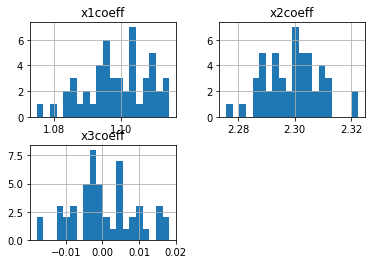

In [5]:
hist = df[['x1coeff','x2coeff','x3coeff']].hist(bins=20)

In [6]:
#copies from last cell

features = ['x1','x2','x3','x4','x5']
coeffs = [1.1,2.3,0,1.1,-2.5]
coeffs_cat = [[('P',0.4),('Q',0.3), ('R',0)],[('a',0),('b',0.1),('c',0.9)]]
features_cat = ['x6','x7']

#Now generates a new data set 
dataset2 = dataset_gen2(features,coeffs,features_cat, coeffs_cat, partial(np.random.normal,0,1),10000)

# function that scales the coefficients up and down, creates some duplicate features, prepares categoricals etc

def transformator(dataset):
    df = dataset.copy()
    
    #stretch numer variables
    df['y1'] = df['x1'].apply(partial(nuller, 0.99,3))
    df['y2'] = df['x2'].apply(partial(nuller, 0.95, 0.5))
    df['y3'] = df['x2'].apply(partial(nuller, 0.90, 2 ))
    df['y4'] = df['x3'].apply(partial(nuller, 0.99, 25))
    df['y5'] = df['x4'].apply(partial(nuller, 0.96, 20))
    df['y6'] = df['x5'].apply(partial(nuller,0.95, 1.2))
    df['y7'] = df['x2'].apply(partial(nuller, 0.96,2 ))
    df['y10'] = (df['x2'] + df['x3']).apply(partial(nuller, 0.6,20))

    # dummy encoding categorical variables
    df['y8'] = pd.Categorical(df.x6)
    df['y9'] = pd.Categorical(df.x7)
    
    # generate date set to give out
    df2 = df[['y1','y2','y3','y4','y5','y6','y7','y8','y9','y10','Target3']].copy()
    df3 = df2.copy()
    df2 = pd.concat([df2, pd.get_dummies(df['y8'], prefix='y8', drop_first=True)], axis=1)
    df2 = pd.concat([df2, pd.get_dummies(df['y9'], prefix='y9', drop_first=True)], axis=1)
    
    return df3, df2
    

dataset3, dataset4 = transformator(dataset2)

collist = dataset4.columns.tolist()
collist.remove('y3')
collist.remove('y7')
collist.remove('y10')

dataset5 = dataset4[collist].dropna().copy()

mod = smf.ols(formula = 'Target3 ~ y1 + y2 + y4 + y5 + y6 + y8_Q + y8_R + y9_b + y9_c', data= dataset5)
res = mod.fit()
print(res.summary())
dataset5['pred']  = res.predict()


                            OLS Regression Results                            
Dep. Variable:                Target3   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.304e+04
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:37:34   Log-Likelihood:                -11990.
No. Observations:                8476   AIC:                         2.400e+04
Df Residuals:                    8466   BIC:                         2.407e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4288      0.024     17.654      0.0

In [7]:
dataset5.head()

y1        y2         y4         y5        y6 y8 y9   Target3  y8_Q  \
0  3.161149  0.129729  23.469533   6.663852  0.084406  R  a  3.184239     0   
2 -0.575779 -0.105315  -6.807807  35.231264 -0.908176  R  b  0.576307     0   
3 -5.256968 -0.431408 -48.413587 -21.214794 -0.319953  Q  c -2.462394     1   
4 -2.076513 -0.015462 -28.121244  -4.675234 -1.239877  R  c  2.286023     0   
5  5.981040 -0.518732 -50.229073   1.469368 -1.198468  P  a  3.017924     0   

   y8_R  y9_b  y9_c      pred  
0     1     0     0  1.911962  
2     1     1     0  3.195985  
3     0     0     1 -3.165306  
4     1     0     1  2.364621  
5     0     0     0  2.818020

In [8]:
dataset6 = dataset_gen2(features,coeffs,features_cat, coeffs_cat, partial(np.random.normal,0,1),2500)

# function that scales the coefficients up and down, creates some duplicate features, prepares categoricals etc

dataset7, dataset8 = transformator(dataset6)

dataset9 = dataset8[collist].dropna().copy()

Xnew = sm.add_constant(dataset9)
y_predict = res.predict(Xnew)
dataset9['pred']  = y_predict
dataset9.head(10)

y1        y2         y4         y5        y6 y8 y9   Target3  y8_Q  \
0  -0.939844 -0.352315 -12.451320  12.207223  0.253018  Q  c  0.261612     1   
2   0.315698  0.593598 -18.019480  29.730729 -0.281290  P  a  5.536767     0   
3   0.749000  1.002464 -46.716997  14.607880  0.384080  R  b  6.824487     0   
4   2.135865  0.272666  11.329718   4.634831  3.538732  P  c -5.677278     0   
5  -1.114718  0.085982  19.475513  27.789809  0.670715  P  b  2.004301     0   
6   2.678245 -0.154801  40.907041   1.877141 -0.128424  R  c  1.868177     0   
7   0.328813  0.655778 -46.116999  23.706772  1.781872  R  c  0.279027     0   
8   0.647542  0.240371  25.317777 -14.304142  0.446206  P  a -2.244494     0   
9   0.409988  0.029716 -10.971216  37.588273 -0.714203  Q  a  4.892049     1   
10  2.423669  0.301128   5.989047   5.970037  1.213394  P  a -1.119444     0   

    y8_R  y9_b  y9_c      pred  
0      0     0     1 -0.597153  
2      0     0     0  5.478916  
3      1     1     0  4.948349  
4      0     0     1 -3.766184  
5      0     1     0  0.630199  
6      1     0     1  1.496244  
7      1     0     1  1.587344  
8      0     0     0  0.052368  
9      0     0     0  4.160183  
10     0     0     0  0.494966

In [13]:
# export the datasets to csv - files to be attached and used for DS assessment
dataset7.to_csv('test.csv')
dataset3.to_csv('train.csv')